Most of the other tutorials show you how to use HoloViews for interactive exploratory visualization of your data.  When used with IPython Notebook, HoloViews also helps you establish a fully reproducible scientific or engineering workflow for generating reports or publications.  That is, HoloViews can create and export figures that feed directly into your papers or web pages, along with records of how those figures were generated and even the actual data, providing a clear chain of provenance for your results.  This tutorial will describe how to export your results in a way that preserves the information about how those results were generated.

In [1]:
import numpy as np
import holoviews as hv
from holoviews.operation import contours
%reload_ext holoviews.ipython

## Exporting specific files

During interactive exploration in the IPython Notebook, your results are always visible within the notebook itself, but you can explicitly request that any IPython cell is exported to an external file on disk:

:RGB   [x,y]   (R,G,B,A)
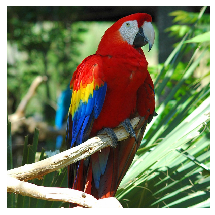

In [2]:
%%output filename="macaw_plot" fig="png" holomap="gif"
parrot = hv.RGB.load_image('../assets/macaw.png')
parrot

You can now load the exported plot back into HoloViews, if you like, though the result would be a bit confusing:

In [ ]:
hv.RGB.load_image('macaw_plot.png')

The ``fig="png"`` part of the ``%%output`` magic above specified that the file should be saved in PNG format, which is useful for posting on web pages or editing in raster-based graphics programs.  It also specified that if the object contained a ``HoloMap`` (which this particular one does not), it would be saved in GIF format.  Objects containing a ``HoloMap`` are handled specially, because these are usually visualized as animations, which are not supported by the common PNG or SVG formats.

For a publication, you will usually want to select SVG format, using ``fig="svg"``, because this vector format preserves the full resolution of all text and drawing elements.  SVG files can be be used in some document preparation programs directly (e.g. [LibreOffice](http://www.libreoffice.org/)), and can easily be converted using e.g. [Inkscape](https://inkscape.org) to PDF for use with PDFLaTeX or to EMF for use with Microsoft Word.  They can also be edited using Inkscape or other vector drawing programs to move graphical elements around, add arbitrary text, etc., if you need to make final tweaks before using the figures in a document.  You can also embed them within other SVG figures in such a drawing program, e.g. by creating a larger figure as a template that automatically incorporates multiple SVG files you have exported separately.

## Exporting notebooks

The ``%%output`` magic is useful when you want specific plots saved into specific files.  Often, however, a notebook will contain an entire suite of results contained in multiple different cells, and manually specifying these cells and their filenames is error-prone, with a high likelihood of accidentally creating multiple files with the same name or using different names in different notebooks for the same objects.

To make the exporting process easier for large numbers of outputs, as well as more predictable, HoloViews also offers a powerful automatic notebook exporting facility, creating an archive of all your results.  Automatic export is very useful in the common case of having a notebook that contains a series of figures to be used in a report or publication, particularly if you are repeatedly re-running the notebook as you finalize your results, and want the full set of current outputs to be available to an external document preparation system.

### Adding files to an archive

To turn on automatic adding of your files to the export archive, run ``holoviews.archive.auto()``:

In [ ]:
hv.archive.auto()

This object's behavior can be customized extensively; try pressing shift-[tab] twice within the parentheses for a list of options, which are described more fully below.

By default, the output will go into a directory with the same name as your notebook, and the names for each object will be generated from the groups and labels used by HoloViews.  Objects that contain HoloMaps are not exported by default, since those are usually rendered as animations that are not suitable for inclusion in publications, but you can add an argument ``holomap='gif'`` if you want those as well.  To see how the auto-exporting works, let's define a few HoloViews objects:

In [ ]:
parrot[:,:,'R'].relabel("Red") + parrot[:,:,'G'].relabel("Green") + parrot[:,:,'B'].relabel("Blue")

In [ ]:
parrot * hv.Arrow(-0.1, 0.2, 'Polly', '>')

In [ ]:
%%opts Contours (linewidth=1.3) Image (cmap="gray")
cs = contours(parrot[:,:,'R'], levels=[0.10,0.80])
cs

We can now list what has been captured, along with the names that have been generated:

In [ ]:
hv.archive.contents()

Here each object has resulted in two files, one in SVG format and one in Python "pickle" format.  We'll ignore the pickle files for now, focusing on the SVG images.

The name generation code for these files is heavily customizable, but by default it consists of a list of dimension values and objects:

  ``{dimension},{dimension},...{group}-{label},{group}-{label},...``.  

The ``{dimension}`` shows what dimension values are included anywhere in this object, if it contains any high-level ``Dimensioned`` objects like ``HoloMap``, ``NdOverlay``, and ``GridLayout``.  In the last SVG image in the contents list above, which is for the ``contours`` object, there is one dimension ``Levels``, and the name shows that dimension values included in this object range from 0.1 to 0.8 (as is visible in the contours specification above.)  Of course, nearly all HoloViews objects have dimensions, such as ``x`` and ``y`` in this case, but those dimensions are not used in the filenames because they are explicitly shown in the plots; only the top-level dimensions are used (those that determine which plot this is, not those that are shown in the plot itself.)

The ``{group}-{label}`` information lists the names HoloViews uses for default titles and for attribute access for the various objects that make up a given displayed object.  E.g. the first SVG image in the list is a ``Layout`` of the three given ``Image`` objects, and the second one is an ``Overlay`` of an ``RGB`` object and an ``Arrow`` object.  This information usually helps distinguish one plot from another, because they will typically be plots of objects that have different labels.  

If the generated names are not unique, a numerical suffix will be added to make them unique.  A maximum filename length is enforced, which can be set with ``holoviews.archive.max_filename=``_num_.

If you prefer a fixed-width filename, you can use a hash for each name instead (or in addition), where ``:.8`` specifies how many characters to keep from the hash:

In [ ]:
hv.archive.filename_formatter="{SHA:.8}"
cs

In [ ]:
hv.archive.contents()

You can see that the newest files added have the shorter, fixed-width format, though the names are no longer meaningful.  If the ``filename_formatter`` had been set from the start, all filenames would have been of this type, which has both practical advantages and disadvantages.

### Generated indexes

In addition to the files that were added to the archive for each of the cell outputs above, the archive exporter also adds an ``index.html`` file with a static copy of the notebook, with each cell labelled with the filename used to save it.  This HTML file acts as a definitive index to your results, showing how they were generated and where they were exported on disk.  

The exporter will also add a cleared, runnable copy of the notebook ``index.ipynb`` (with output deleted), so that you can later regenerate all of the output, with changes if necessary.  

The exported archive will thus be a complete set of your results, along with a record of how they were generated, plus a recipe for regenerating them  -- i.e., reproducible research!

### Adding your own data to the archive

Of course, your results may depend on a lot of external packages, libraries, code files, and so on, which will not automatically be included or listed in the exported archive.

But the archive support is very general, and you can add any object to it that you want to be exported along with your output.  For instance, you can store arbitrary metadata of your choosing, such as version control information, here as a JSON-format text file: 

In [ ]:
import json
hv.archive.add(filename='metadata.json', 
               data=json.dumps({'repository':'git@github.com:ioam/holoviews.git',
                                'commit':'437e8d69'}), info={'mime_type':'text/json'})

The new file can now be seen in the contents listing:

In [ ]:
hv.archive.contents()

In this way, you should be able to automatically generate output files, with customizable filenames, storing any data or metadata you like along with them so that you can keep track of all the important information for reproducing these results later.

### Controlling the behavior of ``holoviews.archive``

The ``holoviews.archive`` object provides numerous parameters that can be changed.  You can e.g.:

- output the whole directory to a single compressed ZIP or tar archive file (e.g. ``archive.set_param(pack=False, archive_format='zip')`` or ``archive_format='tar'``)

- generate a new directory or archive every time the notebook is run (``archive.uniq_name=True``); otherwise the output directory is erased each time 

- choose your own name for the output directory or archive (e.g. ``archive.export_name="{timestamp}"``)

- change the format of the optional timestamp (e.g. to retain snapshots hourly, ``archive.set_param(export_name="{timestamp}", timestamp_format="%Y_%m_%d-%H")``)

These options and any others listed above can all be set in the ``holoviews.archive.auto()`` call at the start, for convenience and to ensure that they apply to all of the files that are added.

### Writing the archive to disk

To actually write the files you have stored in the archive to disk, you need to call ``export()`` after any cell that might contain computation-intensive code.  Usually it's best to do so as the last or nearly last cell in your notebook, though here we do it earlier because we want to show how to use the exported files.

In [ ]:
hv.archive.export()

Shortly after the ``export()`` command has been executed, the output should be available as a directory on disk, by default in the same directory as the notebook file, named with the name of the notebook:  

In [ ]:
import os
os.getcwd()
if os.path.exists("Exporting"):
    print(sorted(os.listdir("Exporting")))

For technical reasons to do with how the IPython Notebook interacts with JavaScript, if you use the IPython command ``Run all``, the holoviews.archive.export() command is not actually executed when the cell with that call is encountered during the run.  Instead, the ``export()`` is queued until after the final cell in the notebook has been executed.  This asynchronous execution has several awkward but not serious consequences:

- It is not possible for the ``export()`` cell to show whether any errors were encountered during exporting, because these will not occur until after the notebook has completed processing.  To see any errors, you can run  ``holoviews.archive.last_export_status()`` separately, *after* the ``Run all`` has completed.  E.g. just press shift-[Enter] in the following cell, which will tell you whether the previous export was successful.

- If you use ``Run all``, the directory listing ``os.listdir()`` above will show the results from the *previous* time this notebook was run, since it executes before the export.  Again, you can use shift-[Enter] to update the data once complete.

- The ``Export name:`` in the output of ``holoviews.archive.export()`` will not always show the actual name of the directory or archive that will be created.  In particular, it may say ``{notebook}``, which when saving will actually expand to the name of your IPython Notebook.

In [ ]:
hv.archive.last_export_status()

### Accessing your saved data

By default, HoloViews saves not only your rendered plots (PNG, SVG, etc.), but also the actual HoloViews objects that the plots visualize, which contain all your actual data.  The objects are stored in Python pickle files (``.pkl``), which are visible in the directory listings above but have been ignored until now.  The plots are what you need for writing a document, but the raw data is is a crucial record to keep as well.  For instance, you now can load in the HoloViews object, and manipulate it just as you could when it was originally defined.  E.g. we can re-load our ``Levels`` ``Overlay`` file, which has the contours overlaid on top of the image, and easily pull out the underlying ``Image`` object:

In [ ]:
import os
from holoviews.core.io import Unpickler
c, a = None,None
path = "Exporting/Levels_0.1-0.8,Overlay,Image,Level.hvz"

if os.path.isfile(path):
    o = Unpickler.load(open(path,"r"))
    c = o.Image
print(repr(c))

Given the ``Image``, you can also access the underlying array data, because HoloViews objects are simply containers for your data and associated metadata. This means that years from now, as long as you can still run HoloViews, you can now easily re-load and explore your data, plotting it entirely different ways or running different analyses, even if you no longer have any of the original code you used to generate the data.  All you need is HoloViews, which is permanently archived on GitHub and is fully open source and thus should always remain available.  Because the data is stored conveniently in the archive alongside the figure that was published, you can see immediately which file corresponds to the data underlying any given plot in your paper, and immediately start working with the data, rather than e.g. laboriously trying to reconstruct the data from a saved figure.

If you do not want the pickle files, you can of course turn them off if you prefer, e.g. by changing ``holoviews.archive.auto()`` to:

```python
from holoviews import Store
holoviews.archive.auto(exporters=[Store.PlotRenderer.instance(holomap=None)])
```

## Reproducible research

The export options from HoloViews help you establish a feasible workflow for doing reproducible research: starting from interactive exploration, either export specific files with ``%%output``, or enable ``holoviews.archive.auto()``, which will store a copy of your notebook and its output ready for inclusion in a document but retaining the complete recipe for reproducing the results later.  

HoloViews also works very well with the [Lancet](http://ioam.github.io/lancet) tool for exploring large parameter spaces, and Lancet provides an interface to HoloViews that makes Lancet output directly available for use in HoloViews.  Lancet, when used with IPython Notebook and HoloViews, makes it feasible to work with large numbers of computation-intensive processes that generate heterogeneous data that needs to be collated, analyzed, and visualized. For more background and a suggested workflow, see our [2013 paper on using Lancet](http://dx.doi.org/10.3389/fninf.2013.00044) with IPython Notebook, though that paper was written before the release of HoloViews and thus does not discuss how HoloViews helps in this process.